In [1]:
import os

if os.environ.get("ECCODES_DIR") is None:
    os.environ["ECCODES_DIR"] = os.path.join(os.environ['HOME'], '.local')


import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt

import src.nzthermo as nzt

In [2]:
step = 1
selection =  (
    # {}
    # {'y':slice(125, 150), 'x':slice(1350, 1375)} # flordia)
    {'y':slice(None, None, 4), 'x':slice(None, None, 4)}
)


T_2m = xr.open_dataset(
    "data/hrrr.t00z.wrfsfcf00.grib2",
    engine="cfgrib",
    filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', "paramId":167}
)['t2m'].isel(selection).to_numpy().reshape(-1, 1)

Q_2m = xr.open_dataset(
    "data/hrrr.t00z.wrfsfcf00.grib2",
    engine="cfgrib",
    filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'heightAboveGround', "paramId":174096}
)["sh2"].isel(selection).to_numpy().reshape(-1, 1)

P_2m = xr.open_dataset(
    "data/hrrr.t00z.wrfsfcf00.grib2",
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "surface", "stepType": "instant"}},
)['sp'].isel(selection).to_numpy().reshape(-1, 1)
# P_2m = xr.open_dataset(
#     "data/hrrr.t00z.wrfsfcf00.grib2",
#     engine="cfgrib",
#     backend_kwargs={"filter_by_keys": {'stepType': 'instant', 'typeOfLevel': 'meanSea'}},
# )['mslma'].isel(selection).to_numpy().reshape(-1, 1)

P_2m.shape, Q_2m.shape
Td_2m = nzt.dewpoint_from_specific_humidity(P_2m, Q_2m)


isobaric = xr.open_dataset(
    "data/hrrr.t00z.wrfprsf00.grib2",
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "isobaricInhPa"}},
).isel(selection)

P_ = isobaric["isobaricInhPa"].to_numpy().astype(np.float32) * 100.0
T_ = isobaric["t"].to_numpy()#.isel(selection).to_numpy()  # (K) (Z, Y, X)
Z, Y, X = T_.shape
N = Y * X
T_ = T_.reshape(Z, N).transpose()  # (N, Z)


Q_ = isobaric["q"].to_numpy()  # (kg/kg) (Z, Y, X)
Q_ = Q_.reshape(Z, N).transpose()  # (N, Z)

Td_ = nzt.dewpoint_from_specific_humidity(P_[np.newaxis], Q_)

In [17]:
def stack(
    isb_pressure:np.ndarray,
    isb_temperature:np.ndarray,
    isb_dewpoint:np.ndarray,
    sfc_pressure:np.ndarray,
    sfc_temperature:np.ndarray,
    sfc_dewpoint:np.ndarray,
):
    N = sfc_pressure.shape[0]
    isb_pressure = isb_pressure.repeat(N).reshape(-1, N).transpose()
    P = isb_pressure.copy()
    T = isb_temperature.copy()
    Td = isb_dewpoint.copy() 

    # P = np.hstack((sfc_pressure, isb_pressure))
    # T = np.hstack((sfc_temperature, isb_temperature))
    # Td = np.hstack((sfc_dewpoint, isb_dewpoint))
      
    # # mask = (P > sfc_pressure) #| np.isclose(P, sfc_pressure)
    
    
    # # plt.imshow(mask.reshape(Y, X, -1)[..., 1], origin='lower')
    # # P[mask] = -np.inf
    # # T[mask] = -np.inf
    # # Td[mask] = -np.inf


    # sort = np.arange(P.shape[0])[:, np.newaxis], np.argsort(P, axis=1) 
    

    # P, T, Td = P[sort][:, ::-1], T[sort][:, ::-1], Td[sort][:, ::-1]

    # nans = ~np.isfinite(P)
    # P[nans] = np.nan
    # T[nans] = np.nan
    # Td[nans] = np.nan
    # # print(P, mask)
    return P, T, Td
    return P[:, :-5], T[:, :-5], Td[:, :-5]



P, T, Td = stack(P_, T_, Td_, P_2m, T_2m, Td_2m)

OROG = xr.open_dataset(
    "data/hrrr.t00z.wrfsfcf00.grib2",
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {'stepType': 'instant', 'typeOfLevel': 'surface'}},
)['orog'].isel(selection).clip(0).to_numpy()
# P *= (OROG.reshape(-1 , 1) + 1)
# P
# OROG / (OROG + 1)


In [18]:
prof = nzt.parcel_profile(P, T[:, 0], Td[:, 0])
prof
CAPE, CIN = nzt.cape_cin(P, T, Td, prof)
# CAPE -= OROG.reshape(-1 , 1)
CAPE = CAPE.reshape(Y, X) 
CIN = CIN.reshape(Y, X)

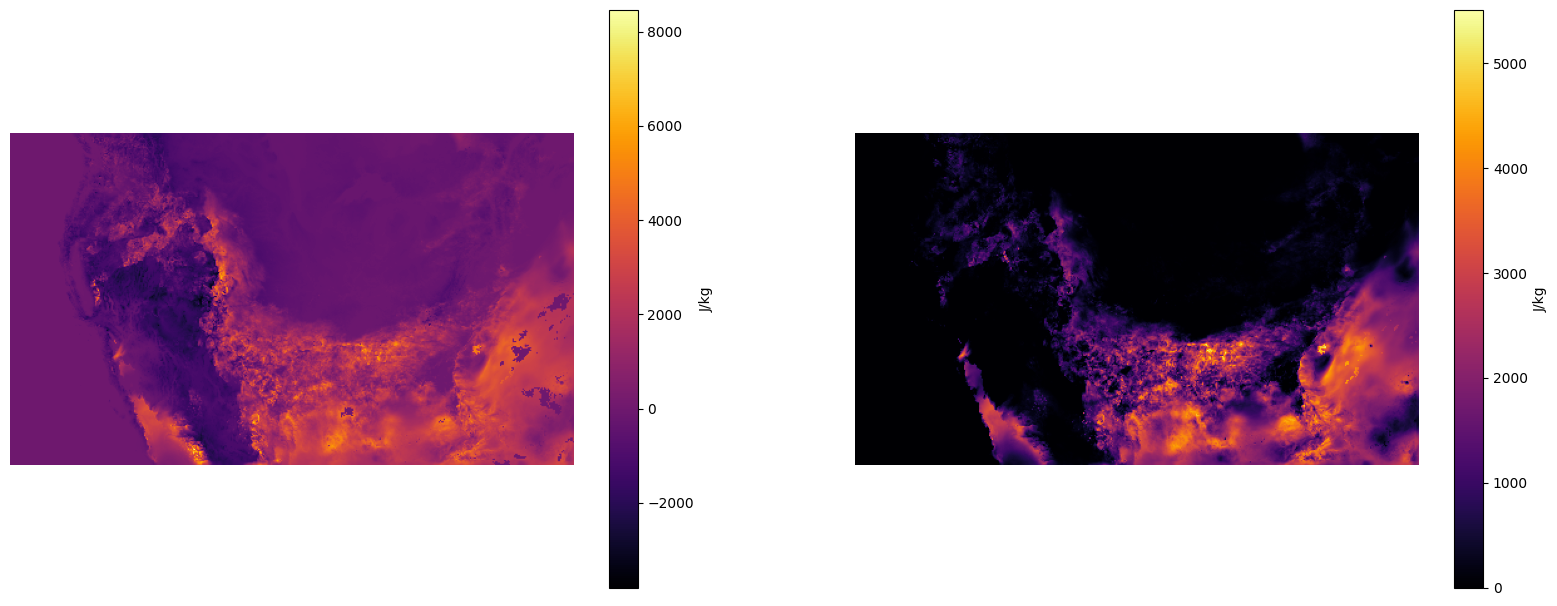

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.axis('off')
ax2.axis('off')

im = ax1.imshow(CAPE - OROG, cmap='inferno', origin='lower')
plt.colorbar(im, ax=ax1, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)

HRRR_CAPE = xr.open_dataset(
    "data/hrrr.t00z.wrfsfcf00.grib2",
    engine="cfgrib",
    backend_kwargs={"filter_by_keys": {"typeOfLevel": "surface", "stepType": "instant"}},
)['cape'].isel(selection)
im = ax2.imshow(HRRR_CAPE, cmap='inferno', origin='lower')
plt.colorbar(im, ax=ax2, orientation="vertical", pad=0.05, label="J/kg", shrink=0.75)

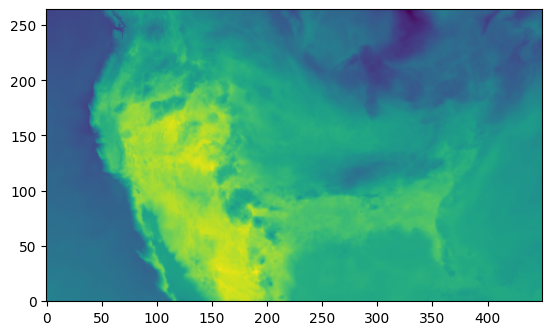

In [6]:
plt.imshow(prof[..., 0].reshape(Y, X), origin='lower')

In [7]:
np.abs(CAPE - HRRR_CAPE).max()

<xarray.DataArray 'cape' ()> Size: 4B
array(inf, dtype=float32)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    valid_time  datetime64[ns] 8B ...